# Chessboard Corner Detection 

This report provides an explanation of the process and results of detecting chessboard corners in a set of calibration images. The goal of this process is to prepare for camera calibration by identifying the corners of a chessboard pattern in multiple images.

---

## **1. Overview**

The script performs the following tasks:
1. **Loads calibration images** containing a chessboard pattern.
2. **Detects chessboard corners** in each image.
3. **Saves the images** with detected corners for visualization.
4. **Stores the 2D and 3D points** of the detected corners for future use in camera calibration.

---

## **2. Key Steps**

### **2.1 Define Chessboard Size**
- The chessboard size is defined as `(9, 7)`, which means the chessboard has 9 columns and 7 rows of inner corners.
- This size must match the actual chessboard used in the calibration images. If it doesn't, the corner detection will fail.

### **2.2 Prepare Object Points**
- Object points (`objp`) represent the 3D coordinates of the chessboard corners in the real world.
- These points are generated assuming the chessboard lies on the `z=0` plane, with each square having a size of `1.0` unit.
- If the actual size of the squares is known, `square_size` should be updated accordingly.

### **2.3 Load and Process Images**
- The script iterates through a list of image paths (`image_paths`).
- Each image is loaded, converted to grayscale, and processed to detect chessboard corners using `cv2.findChessboardCorners`.

### **2.4 Detect Chessboard Corners**
- The function `cv2.findChessboardCorners` is used to detect the corners of the chessboard in the grayscale image.
- If corners are detected (`ret = True`), the 2D image points (`corners`) and corresponding 3D object points (`objp`) are stored in `imgpoints` and `objpoints`, respectively.

### **2.5 Visualize and Save Results**
- Detected corners are drawn on the original image using `cv2.drawChessboardCorners`.
- The image is displayed using `matplotlib` for visualization.
- The image with detected corners is saved to the `output_corners` folder for future reference.

---

## **3. Output**

### **3.1 Detected Corners**
- For each image where the chessboard is successfully detected:
  - The image with detected corners is displayed.
  - The image is saved in the `output_corners` folder with the same filename as the input image.

### **3.2 Error Handling**
- If the chessboard is not detected in an image, a message is printed indicating the failure.

---

## **4. Results**

### **4.1 Successful Detections**
- Images where the chessboard corners are successfully detected are saved in the `output_corners` folder.
- These images can be used to verify the accuracy of the corner detection.

### **4.2 Failed Detections**
- If the chessboard is not detected in an image, the script skips that image and prints an error message.
- Common reasons for failure include:
  - Incorrect chessboard size.
  - Poor image quality (e.g., blur, lighting issues).
  - Chessboard not fully visible in the image.

---

## **5. Next Steps**

The collected `objpoints` and `imgpoints` can now be used for **camera calibration**:
1. Use `cv2.calibrateCamera` to compute the camera matrix, distortion coefficients, and other parameters.
2. Use the calibration results to undistort images and improve the accuracy of computer vision tasks.

---




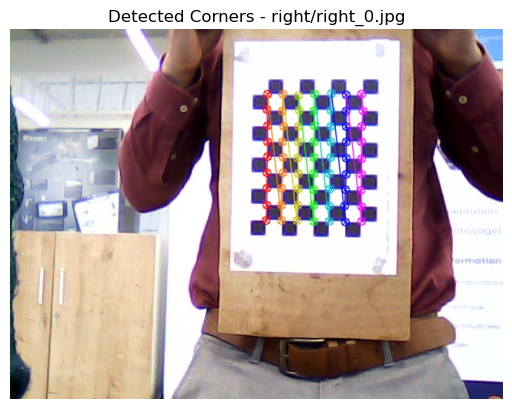

Saved: output_corners\right_0.jpg


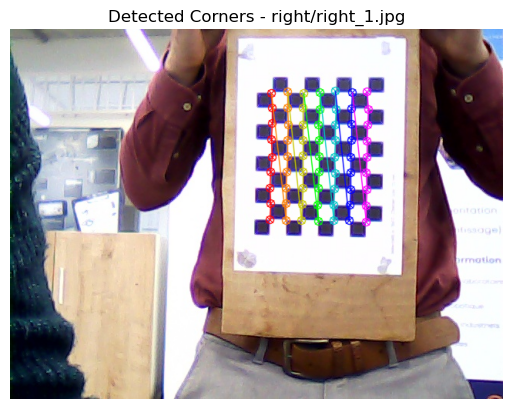

Saved: output_corners\right_1.jpg


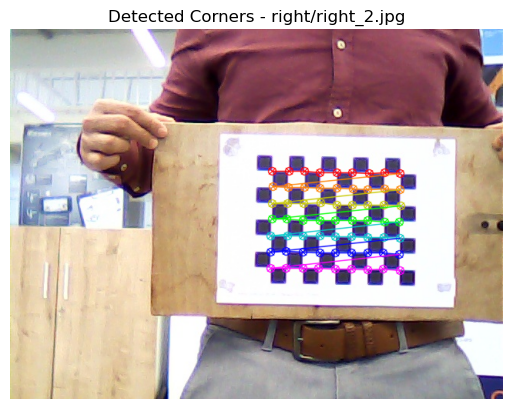

Saved: output_corners\right_2.jpg


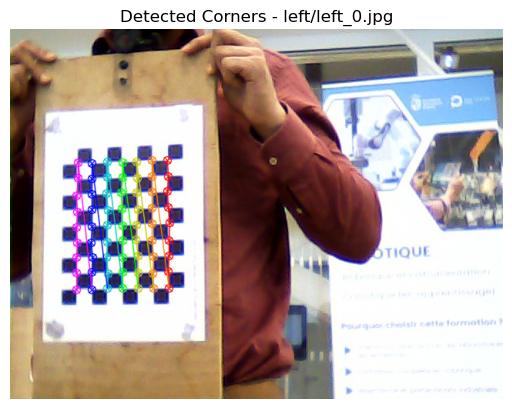

Saved: output_corners\left_0.jpg


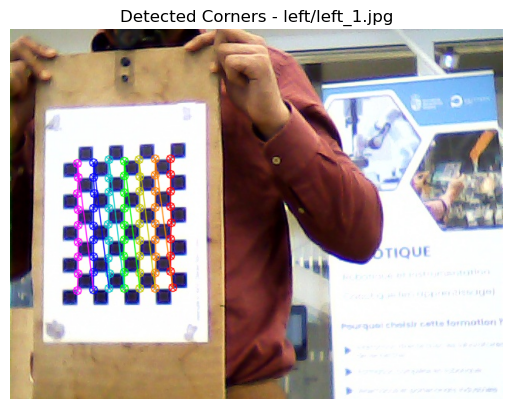

Saved: output_corners\left_1.jpg


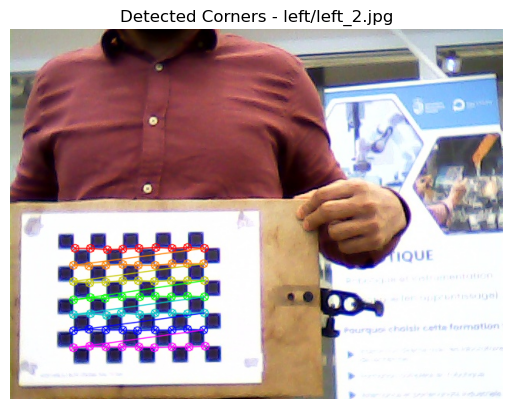

Saved: output_corners\left_2.jpg


In [5]:
 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define chessboard size (Adjust if necessary)
chessboard_size = (9,7 )  # (Columns, Rows) - Change if needed
square_size = 1.0  # Set to 1.0 if unknown

# Prepare object points (3D points of chessboard corners in real-world)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

# Lists to store 3D points (object points) and 2D points (image points)
objpoints = []  # Real-world points
imgpoints = []  # Image points (detected corners)

# List of calibration images (PNG format)
image_paths = ["right/right_0.jpg","right/right_1.jpg","right/right_2.jpg","left/left_0.jpg","left/left_1.jpg","left/left_2.jpg"]

# Create a folder to save output images
output_folder = "output_corners"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read and process each calibration image
for img_path in image_paths:
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Error: Could not load {img_path}")
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    # Detect chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Corners - {img_path}")
        plt.axis("off")
        plt.show()

        # Save the output image with detected corners
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        cv2.imwrite(output_path, img)
        print(f"Saved: {output_path}")
    else:
        print(f"Chessboard not detected in {img_path}")
  





---

## **8. Conclusion**

The script successfully detects chessboard corners in the provided calibration images. The results are saved for further use in camera calibration. If any images fail, ensure the chessboard size is correct and the images are of good quality.

# Camera Calibration Report

This report provides an explanation of the camera calibration process performed using the detected chessboard corners from the previous step. The goal of camera calibration is to compute the intrinsic parameters of the camera (e.g., focal length, optical center) and distortion coefficients, which are essential for correcting lens distortion and improving the accuracy of computer vision tasks.

---

## **1. Overview**

The script performs the following tasks:
1. **Computes the camera intrinsic matrix (`K`)** and **distortion coefficients (`dist`)** using the detected chessboard corners.
2. **Calculates the reprojection error** to evaluate the accuracy of the calibration.
3. **Prints the results** for further analysis.

---

## **2. Key Steps**

### **2.1 Check for Valid Detections**
- The script first checks if valid object points (`objpoints`) and image points (`imgpoints`) are available.
- If no valid detections are found, the calibration process is skipped, and an error message is printed.

### **2.2 Perform Camera Calibration**
- The `cv2.calibrateCamera` function is used to compute the camera parameters:
  - `ret`: A boolean indicating whether the calibration was successful.
  - `K`: The intrinsic matrix (3x3 matrix containing focal lengths and optical center).
  - `dist`: The distortion coefficients (k1, k2, p1, p2, k3, etc.).
  - `rvecs`: Rotation vectors for each image.
  - `tvecs`: Translation vectors for each image.

### **2.3 Compute Reprojection Error**
- The reprojection error measures how accurately the computed camera parameters project the 3D object points back into the 2D image plane.
- For each image:
  - The 3D object points are projected back into the image using `cv2.projectPoints`.
  - The error is computed as the Euclidean distance between the detected corners (`imgpoints`) and the reprojected points (`imgpoints2`).
- The average reprojection error across all images is calculated and printed.

---

## **3. Output**

### **3.1 Intrinsic Matrix (`K`)**
- The intrinsic matrix contains the internal parameters of the camera:

In [9]:
# Performed camera calibration
if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    print("Intrinsic Matrix (K):\n", K)
    print("\nDistortion Coefficients:\n", dist)

    # Computed reprojection error
    reprojection_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        reprojection_error += error
    reprojection_error /= len(objpoints)

    print("\nReprojection Error:", reprojection_error)

else:
    print("Calibration failed: No valid chessboard detections.")


Intrinsic Matrix (K):
 [[2.02000903e+03 0.00000000e+00 2.91857478e+02]
 [0.00000000e+00 1.99604747e+03 1.84051507e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[-1.37466838e+00  1.30448239e+02  4.93230830e-03  7.08938060e-03
  -3.39547959e+03]]

Reprojection Error: 0.11086367915593026


# Image Undistortion Report

This report provides an explanation of the image undistortion process performed using the camera calibration parameters (intrinsic matrix `K` and distortion coefficients `dist`). The goal of undistortion is to correct lens distortion in images, which is essential for improving the accuracy of computer vision tasks such as stereo vision, 3D reconstruction, and object detection.

---

## **1. Overview**

The script performs the following tasks:
1. **Loads left and right images** from specified paths.
2. **Converts the images to grayscale** for undistortion.
3. **Applies undistortion** using the camera intrinsic matrix (`K`) and distortion coefficients (`dist`).
4. **Saves the undistorted images** to an output folder.
5. **Displays the undistorted images** side by side for comparison.

---

## **2. Key Steps**

### **2.1 Define Paths**
- The paths for the input left and right images are defined.
- An output folder (`undistorted_output`) is created to save the undistorted images.

### **2.2 Load Images**
- The left and right images are loaded using `cv2.imread`.
- If the images are not loaded successfully, an error is raised.

### **2.3 Convert to Grayscale**
- The images are converted to grayscale using `cv2.cvtColor`.
- Grayscale conversion simplifies the undistortion process and reduces computational overhead.

### **2.4 Undistort Images**
- The `cv2.undistort` function is used to correct lens distortion in the images.
- The function takes the following inputs:
  - Input image (grayscale).
  - Intrinsic matrix (`K`).
  - Distortion coefficients (`dist`).

### **2.5 Save Undistorted Images**
- The undistorted images are saved to the `undistorted_output` folder with appropriate filenames.

### **2.6 Display Results**
- The undistorted images are displayed side by side using `matplotlib` for visual comparison.

---

## **3. Output**

### **3.1 Undistorted Images**
- The undistorted images are saved in the `undistorted_output` folder:
  - `undistorted_left.jpg`
  - `undistorted_right.jpg`

### **3.2 Visualization**
- The undistorted images are displayed side by side for comparison:
  - **Left Undistorted Image**: Corrected version of the left input image.
  - **Right Undistorted Image**: Corrected version of the right input image.

---

## **4. Results**

### **4.1 Successful Undistortion**
- The undistorted images are saved and displayed successfully.
- Lens distortion (e.g., barrel distortion, pincushion distortion) is corrected in the output images.

### **4.2 Error Handling**
- If the input images cannot be loaded, an error is raised, and the script terminates.

---

## **5. Interpretation of Results**

### **5.1 Undistorted Images**
- The undistorted images should appear more geometrically accurate compared to the original images.
- Straight lines in the real world should appear straight in the undistorted images.

### **5.2 Comparison**
- Compare the original and undistorted images to verify the effectiveness of the undistortion process.
- Pay attention to areas near the edges of the images, where lens distortion is typically more pronounced.

---

## **6. Next Steps**

The undistorted images can now be used for:
1. **Stereo vision tasks**: Compute disparity maps and depth estimation.
2. **3D reconstruction**: Generate 3D models from 2D images.
3. **Feature matching**: Improve the accuracy of feature detection and matching.

---




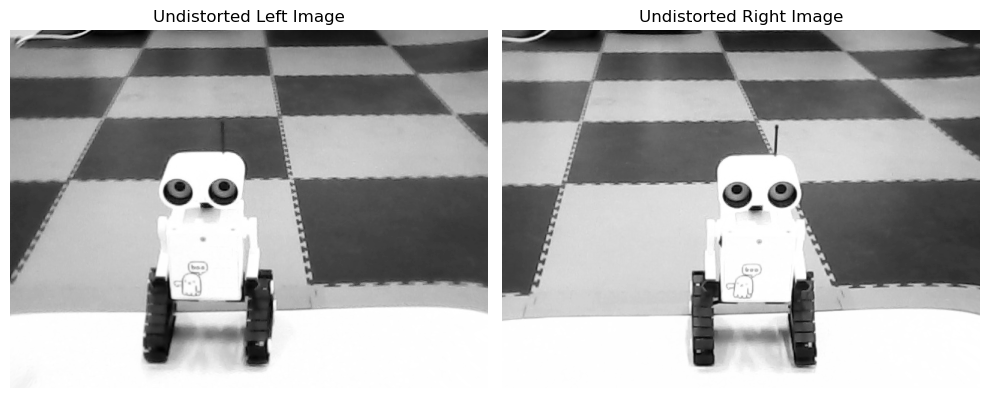

Undistorted images saved to: undistorted_output


In [13]:
import cv2
import matplotlib.pyplot as plt
import os

# Define paths
input_left_path = "left/left_5.jpg"
input_right_path = "right/right_5.jpg"
output_folder = "undistorted_output"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load left and right images
left_img = cv2.imread("left/left_5.jpg")
right_img = cv2.imread("right/right_5.jpg")

# Check if images are loaded successfully
if left_img is None or right_img is None:
    raise FileNotFoundError("One or both images could not be loaded. Check the file paths.")

# Convert images to grayscale
left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# Undistort images using camera matrix (K) and distortion coefficients (dist)
undistorted_left = cv2.undistort(left_gray, K, dist)
undistorted_right = cv2.undistort(right_gray, K, dist)

# Save undistorted images to the output folder
output_left_path = os.path.join(output_folder, "undistorted_left.jpg")
output_right_path = os.path.join(output_folder, "undistorted_right.jpg")
cv2.imwrite(output_left_path, undistorted_left)
cv2.imwrite(output_right_path, undistorted_right)

# Display the undistorted images side by side
plt.figure(figsize=(10, 5))

# Display left undistorted image
plt.subplot(1, 2, 1)
plt.imshow(undistorted_left, cmap="gray")
plt.title("Undistorted Left Image")
plt.axis("off")

# Display right undistorted image
plt.subplot(1, 2, 2)
plt.imshow(undistorted_right, cmap="gray")
plt.title("Undistorted Right Image")
plt.axis("off")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(f"Undistorted images saved to: {output_folder}")

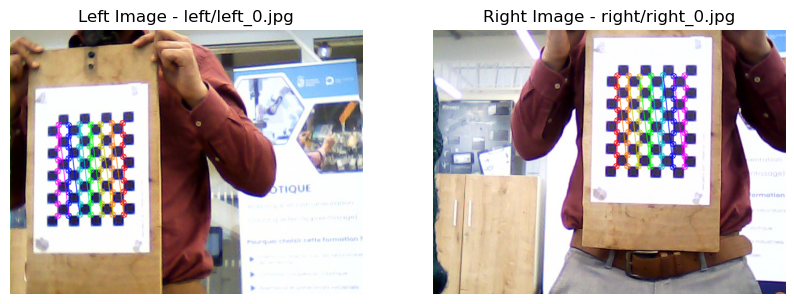

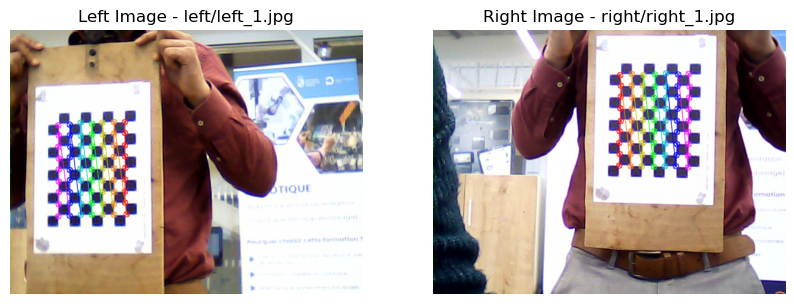

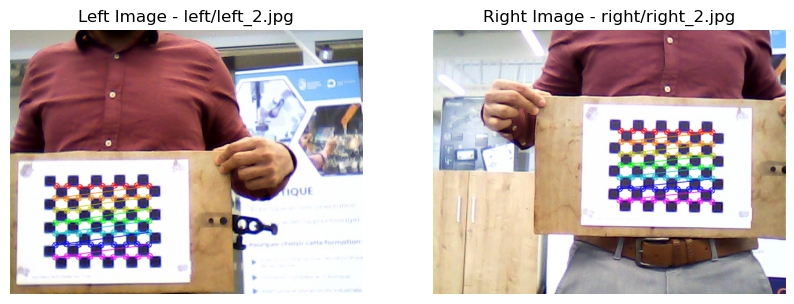

Rotation Matrix (R):
 [[-0.90839984  0.05574989  0.41436901]
 [-0.03937984 -0.99807306  0.04795201]
 [ 0.41624386  0.02724181  0.90884483]]

Translation Vector (T):
 [[-62.69700783]
 [ -7.0122412 ]
 [ 73.39231912]]

Rectification Transforms (R1, R2):
 [[-0.13632589  0.97713459  0.16316632]
 [-0.90698998 -0.05685754 -0.41729653]
 [-0.39847763 -0.20487854  0.89400244]] 
 [[ 0.24592463 -0.96205906  0.11816697]
 [ 0.64782501  0.0724549  -0.75833571]
 [ 0.72100197  0.26304495  0.64106437]]

Projection Matrices (P1, P2):
 [[ 1.97074491e+03  0.00000000e+00 -3.83137022e+02  0.00000000e+00]
 [ 0.00000000e+00  1.97074491e+03  2.92104431e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]] 
 [[ 1.97074491e+03  0.00000000e+00 -3.83137022e+02  0.00000000e+00]
 [ 0.00000000e+00  1.97074491e+03  2.92104431e+03 -1.90730224e+05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]

Euler Angles (in degrees):
 (1.7168758047613253, -24.597672886745112, -

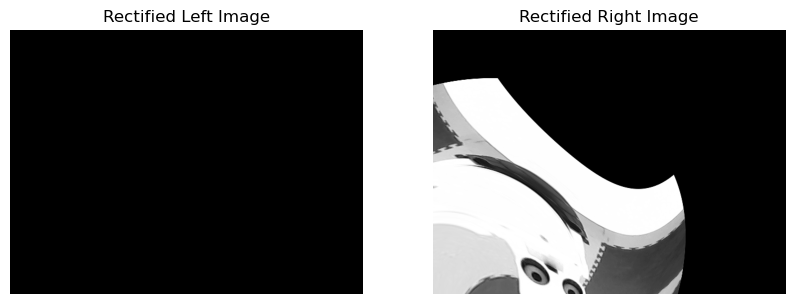

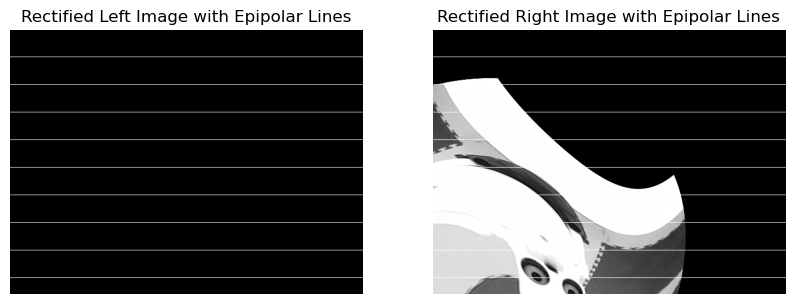

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define chessboard size (Adjust if necessary)
chessboard_size = (9, 7)  # (Columns, Rows) - Change if needed
square_size = 1.0  # Set to 1.0 if unknown

# Prepare object points (3D points of chessboard corners in real-world)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

# Lists to store 3D points (object points) and 2D points (image points)
objpoints = []  # Real-world points
imgpoints_left = []  # Image points for left camera
imgpoints_right = []  # Image points for right camera

# List of calibration images (PNG format)
left_image_paths = ["left/left_0.jpg", "left/left_1.jpg", "left/left_2.jpg"]
right_image_paths = ["right/right_0.jpg", "right/right_1.jpg", "right/right_2.jpg"]

# Read and process each calibration image
for left_path, right_path in zip(left_image_paths, right_image_paths):
    left_img = cv2.imread(left_path)
    right_img = cv2.imread(right_path)
    
    if left_img is None or right_img is None:
        print(f"Error: Could not load {left_path} or {right_path}")
        continue
    
    # Convert to grayscale
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    
    # Detect chessboard corners
    ret_left, corners_left = cv2.findChessboardCorners(left_gray, chessboard_size, None)
    ret_right, corners_right = cv2.findChessboardCorners(right_gray, chessboard_size, None)
    
    if ret_left and ret_right:
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(left_img, chessboard_size, corners_left, ret_left)
        cv2.drawChessboardCorners(right_img, chessboard_size, corners_right, ret_right)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Left Image - {left_path}")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Right Image - {right_path}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Chessboard not detected in {left_path} or {right_path}")

# Perform stereo calibration
if len(objpoints) > 0 and len(imgpoints_left) > 0 and len(imgpoints_right) > 0:
    # Calibrate left and right cameras
    ret_left, K_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints_left, left_gray.shape[::-1], None, None)
    ret_right, K_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints_right, right_gray.shape[::-1], None, None)
    
    # Perform stereo calibration
    flags = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    ret, K_left, dist_left, K_right, dist_right, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints_left, imgpoints_right, K_left, dist_left, K_right, dist_right, left_gray.shape[::-1], criteria=criteria, flags=flags)
    
    print("Rotation Matrix (R):\n", R)
    print("\nTranslation Vector (T):\n", T)
    
    # Perform stereo rectification
    rectify_scale = 1  # Scale factor for rectification (0 means no scaling, 1 means full scaling)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        K_left, dist_left, K_right, dist_right, left_gray.shape[::-1], R, T, alpha=rectify_scale)
    
    print("\nRectification Transforms (R1, R2):\n", R1, "\n", R2)
    print("\nProjection Matrices (P1, P2):\n", P1, "\n", P2)

      # Convert rotation matrix to Euler angles for better interpretation
    rvec, _ = cv2.Rodrigues(R)  # Convert rotation matrix to rotation vector
    euler_angles = cv2.RQDecomp3x3(R)[0]  # Decompose rotation matrix into Euler angles
    print("\nEuler Angles (in degrees):\n", euler_angles)
    
    
    # Compute rectification maps
    left_map1, left_map2 = cv2.initUndistortRectifyMap(K_left, dist_left, R1, P1, left_gray.shape[::-1], cv2.CV_16SC2)
    right_map1, right_map2 = cv2.initUndistortRectifyMap(K_right, dist_right, R2, P2, right_gray.shape[::-1], cv2.CV_16SC2)
    
    # Load left and right images for rectification
    left_img = cv2.imread("left/left_5.jpg")
    right_img = cv2.imread("right/right_5.jpg")
    
    # Convert to grayscale
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    
    # Rectify the images
    rectified_left = cv2.remap(left_gray, left_map1, left_map2, cv2.INTER_LINEAR)
    rectified_right = cv2.remap(right_gray, right_map1, right_map2, cv2.INTER_LINEAR)
    
    # Display the rectified images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rectified_left, cmap="gray")
    plt.title("Rectified Left Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(rectified_right, cmap="gray")
    plt.title("Rectified Right Image")
    plt.axis("off")
    plt.show()
    
else:
    print("Stereo calibration failed: No valid chessboard detections.")

# Draw horizontal lines to verify epipolar alignment
for y in range(0, rectified_left.shape[0], 50):  # Draw lines every 50 pixels
    cv2.line(rectified_left, (0, y), (rectified_left.shape[1], y), (255, 0, 0), 1)
    cv2.line(rectified_right, (0, y), (rectified_right.shape[1], y), (255, 0, 0), 1)

# Display images with epipolar lines
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rectified_left, cmap="gray")
plt.title("Rectified Left Image with Epipolar Lines")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rectified_right, cmap="gray")
plt.title("Rectified Right Image with Epipolar Lines")
plt.axis("off")
plt.show()